In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import itertools as it
from collections import Counter, defaultdict, deque
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.3)

from agents import Agent
from evaluation import get_util
# from model_utils import *

In [5]:
# Need the `dot` command from graphviz to visualize tree with `env.render()`
# -> install graphviz by running BOTH commands below:
# conda install graphviz
# pip install graphviz

# make sure `dot` is in the path
import os
os.environ['PATH'] +=':/home/fredcallaway/miniconda3/envs/mcrl/bin/'

# Mouselab-MDP Environment

We construct a Mouselab-MDP with a symmetric tree structure by specifying a branching structure
and a function `reward(depth) -> Distribution` that specifies the reward distribution for
the nodes at each depth. The ground truth for each environment is determined when the `MouselabEnv`
object is instantiated. We can keep the ground truth constant by specifying a `seed` value. Each
env will have a different ground truth, but if we call `envs = make_envs(n=10, seed=1)` multiple times,
`env[4]` will always have the same ground truth.

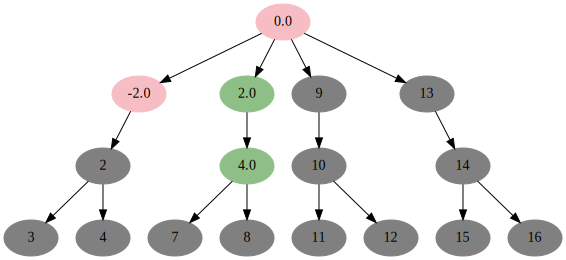

In [163]:
from mouselab import MouselabEnv
from distributions import Categorical, Normal

def make_envs(cost=1.25, n=100, seed=None):
    if seed is not None:
        np.random.seed(seed)
    def reward(depth):
        if depth > 0:
            return Normal(0, 5 * depth).to_discrete(6)
        return 0.
    branching=[4,1,2]
    envs = [MouselabEnv.new_symmetric(branching, reward)
            for _ in range(n)]
    for env in envs:
        env.cost=-cost
    
    return envs

env = make_envs(n=1, seed=17)[0]
env.reset()
for a in [1, 5, 6,]:
    env.step(a)
env.render()

Upon termination, the agent receives the expected return of taking an optimal path given the
current belief state _and_ the ground truth. Unbeknownst to you (or the agent), 
nodes 7 and 8 both have value `6.0`. Thus, the reward for terminating is `12.0`.

In [6]:
# env._term_reward() gives the true termination reward
print('true term reward:     ', env._term_reward())
# env.term_reward() gives the distribution of termination rewards given the current belief.
print('expected term reward: ', env.term_reward().expectation())
# In general, a preceding underscore indicates that an agent should 
# not have access to that method.

true term reward:      12.0
expected term reward:  6.0


# Linear softmax policy

Text(0.5,1,'Features for each action in the state shown above')

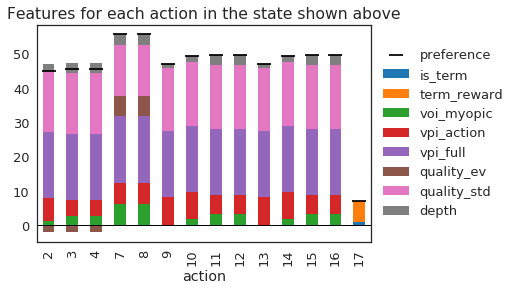

In [8]:
from mouselab_policy import MouselabPolicy

agent = Agent()
theta = np.ones(8)
weights = {
    'is_term': 1,
    'term_reward': 1,
    'voi_myopic': 1,
    'vpi_action': 1,
    'vpi_full': 1,
    'quality_ev': 1,
    'quality_std': 1,
    'depth': 1,
}
pol = MouselabPolicy(weights, temp=1)
agent.register(env)
agent.register(pol)

actions = list(env.actions(env._state))
phi = [pol.phi(env._state, action)[:-1]  # leave out dummy coefficient
       for action in actions]

phi = pd.DataFrame(phi, index=actions, columns=weights.keys())
phi.plot.bar(stacked=True, legend=False)
plt.scatter(range(len(phi)), phi.sum(1), 
            c='k', marker='_', s=200, zorder=10, label='preference')
plt.axhline(0, c='k', lw=1)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xlabel('action')
plt.title('Features for each action in the state shown above')

# Optimized LC policy

In [164]:
from contexttimer import Timer

COSTS = [0.1, 1.25, 4]

def lc_policy(x, normalize_voi=True):
    x = np.array(x)
    assert len(x) == 4, x
    voi = x[1:]
    if normalize_voi and voi.sum():
        voi /= voi.sum()
    # Note: an `is_term` feature is functionally equivalent to a `cost` feature
    # when all clicks have the same cost.
    weights = dict(zip(['is_term', 'voi_myopic', 'vpi_action', 'vpi_full'], x))
    return MouselabPolicy(weights)

def avg_utility(x,train_envs):
    with Timer() as t:
        util = get_util(lc_policy(x), train_envs)
        xs =  np.array2string(np.array(x), 
                              formatter={'float_kind': lambda x: f'{x: 6.2f}'})
        print(f'{xs} -> {util:6.3f}  ({t.elapsed:2.1f} seconds)')
    return util

bounds = [
    (-30., 30.), # is_term
    (0., 1.),    # voi_myopic
    (0., 1.),    # vpi_action
    (0., 1.),    # vpi_full
]

from skopt import gp_minimize

LC_policies = dict()

for c in COSTS:
    envs = make_envs(c,100)
    def loss(x):
        return - avg_utility(x,envs)
    
    result = gp_minimize(loss, bounds, n_calls=10, random_state=0)
    LC_policies[c] = lc_policy(result.x)

LC_policies

[  2.93   0.72   0.60   0.54] -> 13.164  (1.7 seconds)
[ -4.58   0.65   0.44   0.89] -> 19.614  (2.2 seconds)
[ 27.82   0.38   0.79   0.53] -> -0.245  (0.5 seconds)
[  4.08   0.93   0.07   0.09] -> 12.777  (1.3 seconds)
[-28.79   0.83   0.78   0.87] -> 24.075  (3.6 seconds)
[ 28.72   0.80   0.46   0.78] -> -0.245  (0.5 seconds)
[-22.90   0.64   0.14   0.94] -> 23.952  (3.5 seconds)
[  1.31   0.41   0.26   0.77] -> 18.143  (2.1 seconds)
[ -2.63   0.57   0.02   0.62] -> 19.694  (2.1 seconds)
[  6.73   0.62   0.94   0.68] ->  9.900  (1.4 seconds)
[  2.93   0.72   0.60   0.54] ->  7.510  (1.7 seconds)
[ -4.58   0.65   0.44   0.89] -> 13.220  (2.3 seconds)
[ 27.82   0.38   0.79   0.53] -> -0.785  (0.5 seconds)
[  4.08   0.93   0.07   0.09] ->  7.870  (1.4 seconds)
[-28.79   0.83   0.78   0.87] ->  6.690  (3.8 seconds)
[ 28.72   0.80   0.46   0.78] -> -0.785  (0.5 seconds)
[-22.90   0.64   0.14   0.94] ->  9.883  (3.6 seconds)
[  1.31   0.41   0.26   0.77] -> 11.155  (2.0 seconds)
[ -2.63   

{0.1: <mouselab_policy.MouselabPolicy at 0x7fb0f519c3c8>,
 1.25: <mouselab_policy.MouselabPolicy at 0x7fb0f3f0fc50>,
 4: <mouselab_policy.MouselabPolicy at 0x7fb0f3b137f0>}

In [10]:
test_envs = make_envs(1.25, n=100)


training_set_performance = get_util(opt_pol,train_envs)
test_set_performance = get_util(opt_pol,test_envs)



In [11]:
training_set_performance

21.600000000000001

In [13]:
test_set_performance

24.0

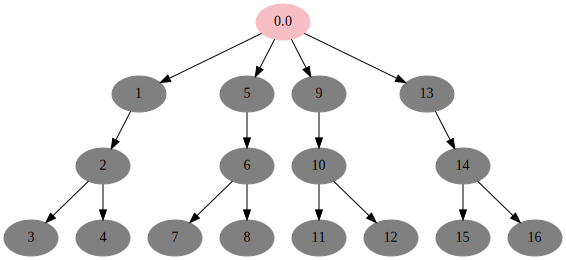

AttributeError: 'NoneType' object has no attribute 'render'

In [16]:
from agents import run_episode
from model_utils import render_trace

env = make_envs(n=1)[0]
trace = run_episode(opt_pol, env)
render_trace(trace,env)

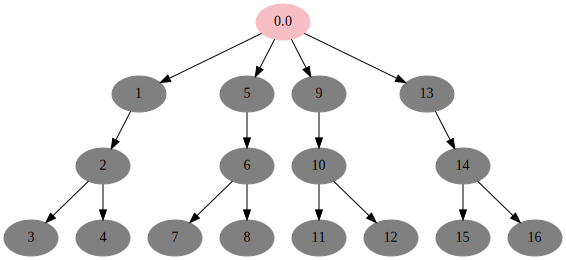

In [17]:
env.reset()
env.render()

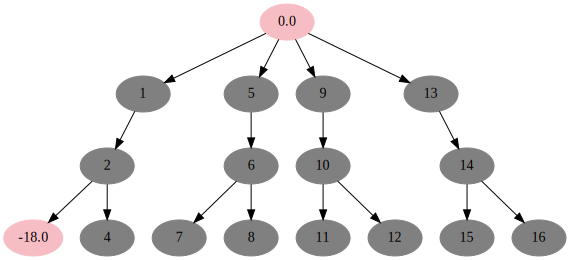

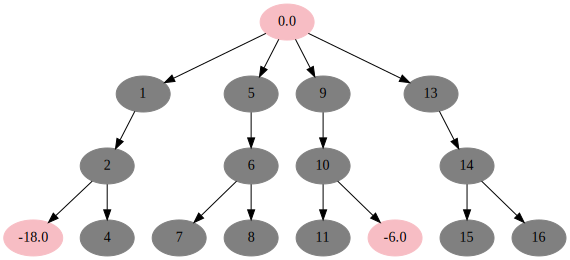

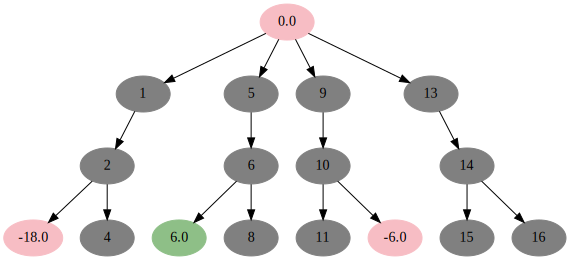

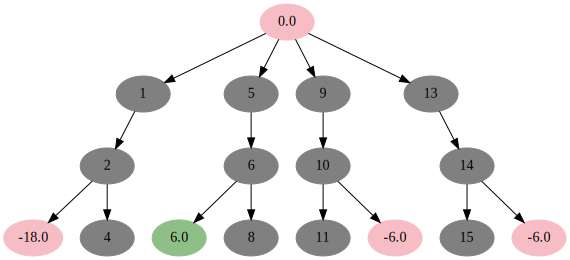

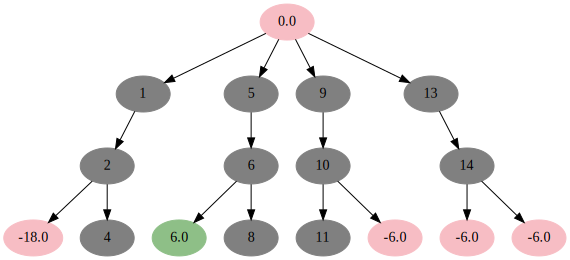

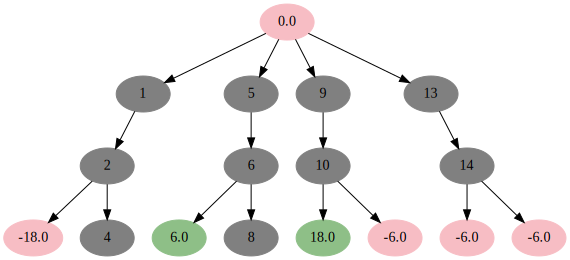

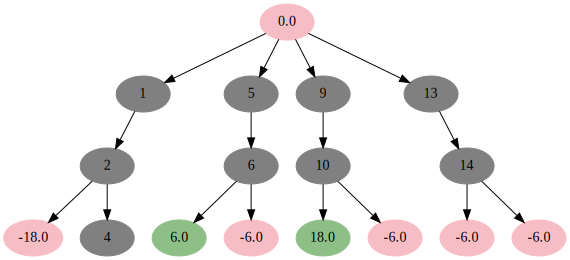

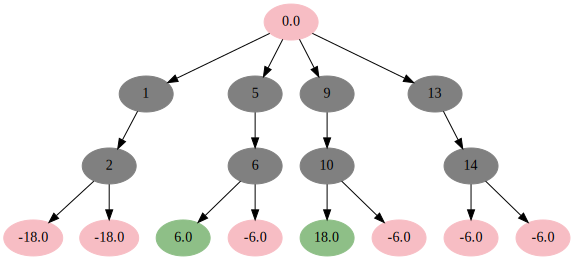

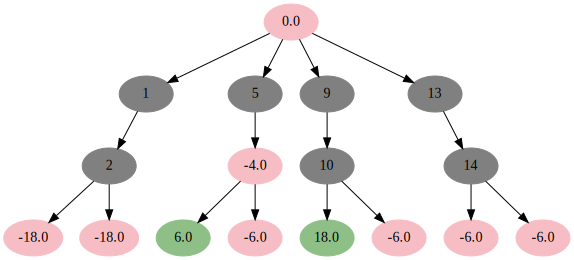

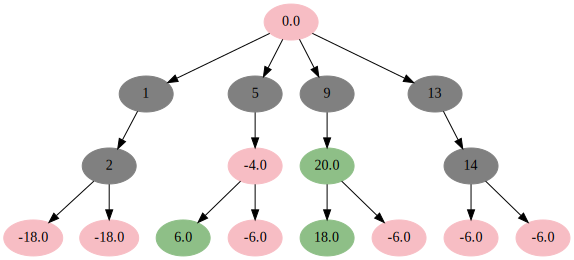

[3, 12, 7, 16, 15, 11, 8, 4, 6, 10, 17]


In [32]:
env = make_envs(n=1)[0]
trace = run_episode(opt_pol, env)


env.reset()
for a in trace['actions'][0:-1]:
    env.step(a)
    env.render() 

print(trace['actions'])    
#env.render()    
#env.render()
#trace['actions'][0]

In [ ]:
from agents import run_episode
pol = MouselabPolicy({'quality_ev': 1})
env = make_envs(n=1)[0]
trace = run_episode(pol, env)
trace['actions']

In [165]:
from evaluation import *
from model_utils import *
from utils import *

import pandas as pd
from policies import FixedPlanPolicy
from joblib import delayed, Parallel
from tqdm import tqdm
from toolz import partition_all

COSTS = [0.1, 1.25, 4.]
term_action = 17

def eval_envs(cost, envs):
    policies = {
        'BO': LC_policies[cost],
        'full-observation': FixedPlanPolicy(range(1, term_action+1)),
        'none': FixedPlanPolicy([term_action]),
    }
    def loop():
        for name, pol in policies.items():
            for _ in range(30):
                df = evaluate(pol, envs)
                df['env'] = envs
                df['agent'] = name
                df['cost'] = cost
                yield df
    return pd.concat(loop())



envs_per_cost = 10#5000
chunks_per_job = 5
total_envs = envs_per_cost * len(COSTS)
n_job = 1
envs_per_chunk = total_envs // (n_job * chunks_per_job)


jobs = [delayed(eval_envs)(cost_var, envs) 
        for cost_var in COSTS
            for envs in partition_all(envs_per_chunk, 
                                  make_envs(cost_var, envs_per_cost))]
result = Parallel(n_job)(tqdm(jobs))
#pd.concat(result).to_pickle('data/eval_envs.pkl')

100%|██████████| 6/6 [00:51<00:00,  8.62s/it]


In [166]:
results = pd.concat(result)
#results['performance'] = results.util - results.cost*results.observations

#print(result[0].groupby(['agent','cost']).describe)

#results.agent=='BO'
#results.cost==0.1
#results[np.logical_and(results.agent=='BO',results.cost==0.1)].util.describe()

#results.groupby('agent').util.describe()
#results.groupby('cost').util.describe()
print(results.groupby(['agent','cost']).util.describe())
print(results.groupby(['agent','cost']).observations.describe())
#results.util(np.logical_and(results.agent=='BO',results.cost==0.1))

                       count       mean        std   min    25%    50%  \
agent            cost                                                    
BO               0.10  300.0  28.422667  11.835925   2.4  22.40  35.10   
                 1.25  300.0  14.399167  11.586307  -7.5   6.25  14.00   
                 4.00  300.0  -1.177778  15.911202 -60.0 -10.00   0.00   
full-observation 0.10  300.0  28.400000  11.508322   2.4  22.40  34.40   
                 1.25  300.0   4.000000   7.810464  -8.0   0.00   2.00   
                 4.00  300.0 -38.800000  11.619382 -56.0 -52.00 -40.00   
none             0.10  300.0   1.550000   4.504457  -8.0   0.00   1.50   
                 1.25  300.0  -3.700000   5.468976 -13.5  -7.50  -4.00   
                 4.00  300.0  -2.250000   4.918653  -9.0  -6.00  -3.25   

                          75%    max  
agent            cost                 
BO               0.10  39.225  39.80  
                 1.25  22.750  34.75  
                 4.00   8.000

In [137]:
LC_policies[0.1].weights

OrderedDict([('is_term', -28.786896153580457),
             ('term_reward', 1),
             ('voi_myopic', 0.33562706510652707),
             ('vpi_action', 0.31367312214646487),
             ('vpi_full', 0.35069981274700812),
             ('quality_ev', 0),
             ('quality_std', 0),
             ('depth', 0)])

In [141]:

results.performance

0    23.5
1    18.4
2    27.4
3    43.4
4    14.4
5    14.4
0    23.4
1    18.4
2    27.8
3    43.7
4    14.4
5    14.4
0    23.2
1    18.4
2    27.3
3    43.6
4    14.4
5    14.4
0    23.3
1    18.4
2    27.2
3    43.7
4    14.4
5    14.4
0    22.4
1    18.4
2    27.7
3    43.3
4    14.4
5    14.4
     ... 
2    -3.5
3     0.5
0    16.0
1    -1.5
2    -3.5
3     0.5
0    16.0
1    -1.5
2    -3.5
3     0.5
0    16.0
1    -1.5
2    -3.5
3     0.5
0    16.0
1    -1.5
2    -3.5
3     0.5
0    16.0
1    -1.5
2    -3.5
3     0.5
0    16.0
1    -1.5
2    -3.5
3     0.5
0    16.0
1    -1.5
2    -3.5
3     0.5
Length: 2700, dtype: float64

In [43]:
envs_per_chunk

0

In [44]:
n_job

22

In [154]:
for env in jobs[0][1][1]:
    env.cost=4

In [157]:
jobs[0][1][1][2].cost

4